# lsh final 

### install libraries

In [1]:
# Update environment (if needed)
# !sudo apt update

# Download and install Java
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Apache Spark 3.0.3 with Hadoop 3.2
!wget -nc -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz

# Unzip the folder
!tar xf  spark-3.0.3-bin-hadoop3.2.tgz

# Install findspark library that will locate Spark on the system
!pip install -q findspark

E: Package 'openjdk-8-jdk-headless' has no installation candidate


In [2]:
# Setting the environment variables, to enable running PySpark in Colab environment.

import os
import shutil
from itertools import islice
import requests

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
#from pyspark.sql import functions as F
from pyspark.sql.types import *

from pyspark.sql.functions import mean, stddev

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import sys
print(sys.version)
print(spark.version)

3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49) 
[GCC 7.5.0]
3.0.1


In [4]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

### Load data & EDA

In [6]:
from google.cloud import storage

In [6]:
directory = 'gs://msca-bdp-tweets/final_project/'
file = '*.json'
path = directory + file
#path = directory

In [7]:
%%time

tweets_df = spark.read.json(path)

CPU times: user 30.8 ms, sys: 11.8 ms, total: 42.6 ms
Wall time: 4min 15s


In [8]:
tweets_df_cleaned=tweets_df.select('coordinates','created_at', 'geo','id_str','place', 'lang',
                                   'is_quote_status','quote_count','quoted_status','quoted_status_id_str',
                                   'retweeted','retweet_count','retweeted_status','text',
                                   'timestamp_ms','user')
tweets_df_covid=tweets_df_cleaned.filter(tweets_df_cleaned.text.contains('covid')|\
                                         tweets_df_cleaned.text.contains('COVID')|\
                                         tweets_df_cleaned.text.contains('Covid')|\
                                         tweets_df_cleaned.text.contains('Coronavirus')|\
                                         tweets_df_cleaned.text.contains('coronavirus'))
tweets_df_covid=tweets_df_covid.dropDuplicates()

In [ ]:
import pyspark.sql.functions as F

def flatten_df(nested_df):
    flat_cols = [c[0] for c in nested_df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in nested_df.dtypes if c[1][:6] == 'struct']

    flat_df = nested_df.select(flat_cols +
                               [F.col(nc+'.'+c).alias(nc+'_'+c)
                                for nc in nested_cols
                                for c in nested_df.select(nc+'.*').columns])
    return flat_df

df_text_raw=flatten_df(tweets_df_covid[['id_str','text','user']])
df_text_raw=df_text_raw[[]]

In [12]:
#save table as parquet
output_directory = 'gs://msca-bdp-students-bucket/shared_data/charleneyu/df_text_raw'
df_text_raw.write.format("parquet").\
mode('overwrite').\
save(output_directory)

In [84]:
#read 5000 samples
#output_directory= "gs://msca-bdp-students-bucket/shared_data/charleneyu/df5000" 
#df_5000 = spark.read.parquet(output_directory) 

#read 5000 samples
#output_directory= "gs://msca-bdp-students-bucket/shared_data/charleneyu/df_text/*.json" 
#df_text = spark.read.json(output_directory)

In [7]:
output_directory= 'gs://msca-bdp-students-bucket/shared_data/charleneyu/lsh_data_user_text'
df_text = spark.read.parquet(output_directory) 

In [8]:
df_text.show(2)

+-------------------+--------------------+---------+-------------------+---------------+
|             id_str|                text|type_user|        user_id_str|original_or_not|
+-------------------+--------------------+---------+-------------------+---------------+
|1453009115911970816|@AM980News Still ...|   others|          279200024|              1|
|1454565501401583622|@KristinaMathews ...|   others|1150191880497291264|              1|
+-------------------+--------------------+---------+-------------------+---------------+
only showing top 2 rows



In [9]:
df_text.count()

4337628

In [11]:
df_text=df_text[['type_user','id_str','text']]

In [12]:
# select title column
#df_text_raw = df_text
#df_text.select(["text"])
#df_text_raw.limit(5)

### Step 1.  Clean the data, remove stopwords and create index

In [13]:
text = df_text.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 8] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()


In [14]:
#row = Row('text')
#df_text_t = text.map(row).zipWithIndex().toDF(['text','id'])
#df_text_t.show(2, False)

In [15]:
df_text_t = df_text.rdd.zipWithIndex().toDF(['text','id'])
#row = Row('text')
#df_text_t = text.map(row).zipWithIndex().toDF(['text','id'])
df_text_t.show(5, False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|text                                                                                                                                                                      |id |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---+
|[others, 1453009115911970816, @AM980News Still ..one third of cases are fully vaccinated. So people are still getting and passing covid]                                  |0  |
|[others, 1454565501401583622, @KristinaMathews @VP You are disgusting. Kids are dropping dead from the vax not covid.]                                                    |1  |
|[others, 1454565712807202818, FDA Approves Pfizer Covid Vaccine For Kids Ages 5 to 11
https://t.co/1FAPt1HgSK]    

In [16]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
#get the item from this array because there is only one item in the array.
df_tokens.limit(5).toPandas()

,list_of_words,id
0,[increased],3
1,[apparently],5
2,[vaccination],7
3,[throughout],8
4,[spokeswoman],10


In [17]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



### Step 2. Fit countvectorizer to create word features

In [18]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [19]:
df_vectorize.limit(5).toPandas()

,list_of_words,id,features
0,[increased],3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,[apparently],5,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,[vaccination],7,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,[throughout],8,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,[spokeswoman],10,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


### Step 3. Fit MinHashLSH to create hash table

**Note:** Adding more hash tables will increase the accuracy at the expense of training time

In [20]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [21]:
df_hashed_text = df_text_t.join(df_hashed, "id", how = 'left')
df_hashed_text.limit(5)
#hashes are compressed version of the features.

id,text,list_of_words,features,hashes
19,"[influencers, 145...","[vaccinated, secr...","(58512,[0,14],[1....","[[4.7945584E7], [..."
54,"[others, 14501987...",null,null,null
296,"[others, 14499248...",null,null,null
926,"[others, 14569776...",null,null,null
965,"[others, 14533720...",[recovered],"(58512,[45],[1.0])","[[7.02914975E8], ..."


In [22]:
df_hashed_text.select("features").limit(1).toPandas()

,features
0,None


### Step 3.1 Jaccard Distance

#### Jaccard Distance = 0.3

In [23]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )

In [24]:
df_dups_30 = df_dups_text

In [ ]:
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,325682,3949812,"(others, 1451536781032235017, The Marxist Teachers Unions and Progressive School Boards are setting the course for Covid and Critical Race Theory… https://t.co/TqXYD41bJa)","(others, 1456065242350428165, @TheFirstonTV @BillOReilly If only bill didn’t sound like a progressive when it comes to covid, masks, and mandates.)"
1,0.0,1008066,3047133,"(others, 1450238875318751239, Alabama Uses Covid Funds to Imprison More Black People: Very ""On Brand"" - LA Progressive https://t.co/NUUO9ANDmH)","(others, 1452684359568404481, @Greg75674800 @laurenboebert Fauci's progressive response to Covid: https://t.co/0B2q33jesZ)"
2,0.0,1212613,2293891,"(others, 1451041623480143876, Science Has Become a Progressive Platform During Covid https://t.co/HEZVN0rwkT)","(others, 1450907464119906307, One of the myriad ways #COVID19 funding has been diverted to support progressive politics…)"
3,0.0,1212613,3047133,"(others, 1451041623480143876, Science Has Become a Progressive Platform During Covid https://t.co/HEZVN0rwkT)","(others, 1452684359568404481, @Greg75674800 @laurenboebert Fauci's progressive response to Covid: https://t.co/0B2q33jesZ)"
4,0.0,1212613,2942960,"(others, 1451041623480143876, Science Has Become a Progressive Platform During Covid https://t.co/HEZVN0rwkT)","(others, 1457777032570441731, @ClayTravis He has Covid and it would be a disaster if the liberal leader of the most progressive state has Covid.… https://t.co/DLWa8Rc0qF)"


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  4337628
Duplicate titles based on { 0.3 } jaccard distance:  776952
Unique titles based on { 0.3 } jaccard distance:  0.3 :  3560676


### Bar Chart visualization for two variables (count of unique and count of “near-duplicate”)

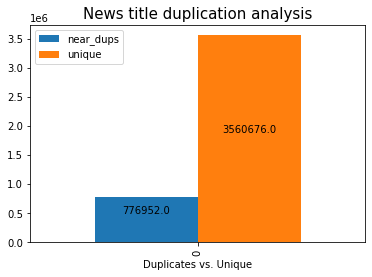

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Jaccard Distance = 0.5

In [ ]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )  

In [ ]:
df_dups_50 = df_dups_text

In [ ]:
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,770641,1066696,"(others, 1453493485248540672, @RagnarrLobrok @SandyAnzaldo @BreitbartNews This is somehow helping your point in supporting the Covid Gremlin?)","(others, 1450654186308243458, We're more than just IT. Supporting local is 1 of the keys to Australia’s economic survival against COVID. That's… https://t.co/SaYFmCru03)"
1,0.0,770641,2221746,"(others, 1453493485248540672, @RagnarrLobrok @SandyAnzaldo @BreitbartNews This is somehow helping your point in supporting the Covid Gremlin?)","(others, 1455264049650933764, Happy Mon night Team English!\n\nWe're all about supporting ECTs tonight. Yes it's been an odd post-covid return to s… https://t.co/R92QWJRuBV)"
2,0.0,770641,3660041,"(others, 1453493485248540672, @RagnarrLobrok @SandyAnzaldo @BreitbartNews This is somehow helping your point in supporting the Covid Gremlin?)","(others, 1450993331626938369, @Filbert19500579 @SFist And you ""Show Me Your Papers"" Nazis are all sell outs for supporting a business that served meat before Covid)"
3,0.0,770641,2943495,"(others, 1453493485248540672, @RagnarrLobrok @SandyAnzaldo @BreitbartNews This is somehow helping your point in supporting the Covid Gremlin?)","(others, 1451944186865979399, @ratboy101203 @BlackBearNews1 @EricTopol Not when you're supporting giving them Covid. We know the long term effect… https://t.co/9N6B4cT7ky)"
4,0.0,770641,3613244,"(others, 1453493485248540672, @RagnarrLobrok @SandyAnzaldo @BreitbartNews This is somehow helping your point in supporting the Covid Gremlin?)","(others, 1454724938632474626, #Covid #HOAX #CrimesAgainstHumanity They are stealing our democracies. MEPs Supporting the rights of workers agai… https://t.co/py8BW29dAA)"


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  4337628
Duplicate titles based on { 0.5 } jaccard distance:  822216
Unique titles based on { 0.5 } jaccard distance:  0.5 :  3515412


### Bar Chart visualization for two variables (count of unique and count of “near-duplicate”)

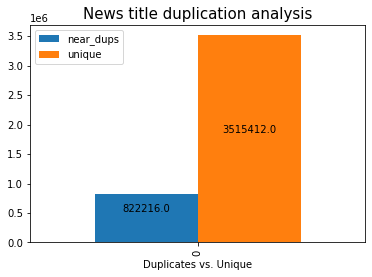

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

#### Jaccard Distance = 0.7

In [ ]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [ ]:
df_dups_70 = df_dups_text

In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  4337628
Duplicate titles based on { 0.7 } jaccard distance:  645603
Unique titles based on { 0.7 } jaccard distance:  0.7 :  3692025


### Bar Chart visualization for two variables (count of unique and count of “near-duplicate”)

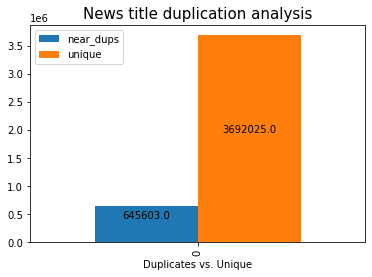

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Step 3.2 Compare thresholds side-by-side

Select all pairs of duplicate titles across jaccard similarities

In [ ]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

224370108
215771322
225488024


In [ ]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")


In [ ]:
dups_combined.limit(10)

text_A,text_B,id_70_A,id_70_B,id_50_A,id_50_B,id_30_A,id_30_B
"[influencers, 145...","[others, 14515697...",12,3551855,null,null,null,null
"[others, 14551238...","[others, 14507088...",30,3749134,null,null,null,null
"[influencers, 145...","[news, 1452512781...",32,33231,null,null,null,null
"[influencers, 145...","[others, 14532591...",32,34264,null,null,null,null
"[influencers, 145...","[others, 14574618...",32,57522,null,null,null,null
"[influencers, 145...","[others, 14512412...",32,153231,null,null,null,null
"[influencers, 145...","[others, 14555319...",32,168334,null,null,null,null
"[influencers, 145...","[others, 14511771...",32,171629,null,null,null,null
"[influencers, 145...","[others, 14581232...",32,185676,null,null,null,null
"[influencers, 145...","[others, 14549350...",32,237447,null,null,null,null


In [ ]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

dups_combined.limit(10)

text_A,text_B,threshold_30,threshold_50,threshold_70
"[others, 14560416...","[others, 14526874...",Non-Dup,Non-Dup,Duplicate
"[others, 14560416...","[others, 14573875...",Non-Dup,Non-Dup,Duplicate
"[others, 14560416...","[others, 14526450...",Duplicate,Duplicate,Duplicate
"[others, 14560416...","[others, 14498437...",Duplicate,Duplicate,Duplicate
"[others, 14560416...","[others, 14506626...",Non-Dup,Non-Dup,Duplicate
"[others, 14560416...","[others, 14586092...",Non-Dup,Non-Dup,Duplicate
"[others, 14560416...","[others, 14509362...",Duplicate,Duplicate,Duplicate
"[others, 14560416...","[others, 14551461...",Duplicate,Duplicate,Duplicate
"[others, 14560416...","[others, 14573109...",Duplicate,Duplicate,Duplicate
"[others, 14551238...","[others, 14530948...",Non-Dup,Non-Dup,Duplicate


#### Select a sample of records across 3 thresholds (jaccard similarities):
* Records that are marked as duplicate by all three thresholds (meet the level of **threshold_30**)
* Records that are identified as non-duplicate by **threshold_30**, while being marked as dups by both **threshold_40** and **threshold_50**
* Records that are identified as non-duplicate by both **threshold_30** and **threshold_40**, while being marked as dups by **threshold_50**

In [ ]:
dups_combined_sample = \
dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_50', 'threshold_70')

In [ ]:
pd.set_option('display.max_rows', 30)
dups_combined_sample.toPandas()

,text_A,text_B,threshold_30,threshold_50,threshold_70
0,"(others, 1456041660010438664, smh when a athlete is showing out they Covid test them..I’m convinced 🤦🏾‍♂️)","(others, 1457013604289503241, @TheVoxWolf Had a tiler do some work at my our house recently couple of weeks ago. Convinced he had got covid he we… https://t.co/Q3bIH2chgU)",Duplicate,Duplicate,Duplicate
1,"(others, 1458989453582635011, We didn't kill the workplace. Everyone went digital bc of covid and we are now entering the workplace as people who… https://t.co/tWeyW3AwJY)","(others, 1456503888295698434, I went to my workplace after leave. People are nice and happy. No talk about covid, just some concerns that activit… https://t.co/EeioYyRwfc)",Duplicate,Duplicate,Duplicate
2,"(others, 1458989453582635011, We didn't kill the workplace. Everyone went digital bc of covid and we are now entering the workplace as people who… https://t.co/tWeyW3AwJY)","(others, 1450742345151000576, ✔️ Stay Covid-safe this autumn and winter with Lancashire's new workplace resource pack.\n\n💻 The pack contains all t… https://t.co/JdFbc55Q1I)",Duplicate,Duplicate,Duplicate
3,"(others, 1456201325989941248, I've been everywhere these past 20 months trying to get covid. I've failed. I've been an athlete since I was 6. I d… https://t.co/Vsn7KF7llo)","(others, 1458959719641485339, @GeoffRissole @BLACKCAPS Maybe because Covid is everywhere in Auckland...)",Duplicate,Duplicate,Duplicate
4,"(others, 1450125277514764289, PM congratulates Uttarakhand for 100% first dose covid vaccination coverage https://t.co/MXEJ9X84fL)","(others, 1450470741544144897, PM congratulates Uttarakhand for 100% first dose covid vaccination coverage\n https://t.co/Ve3WybnT2Y\n\nvia NaMo App https://t.co/oTzr9ra7y0)",Duplicate,Duplicate,Duplicate
5,"(others, 1452245839301292035, ✅ Need to expand the stipend program for secondary students, and boys in particular, to counter child labour\n\n#education #COVID19)","(others, 1452960910675427339, @MiHazank Secondary effects work. Against covid not sure..)",Duplicate,Duplicate,Duplicate
6,"(others, 1457846966117814276, @Unlearned_Hand The paper’s conclusion requires that we say “people who never had covid and people who tested posit… https://t.co/fCefzb3zQO)","(others, 1454989779293069312, WHO HURT HIM😭😭\n\nIn conclusion “Covid he the hell out!” 😭😭)",Duplicate,Duplicate,Duplicate
7,"(others, 1453691804122034182, Good news for those traveling to/from Armenia and UK - now you can use your EU Digital Covid Certificate. Brought t… https://t.co/2yt8fCvrRw)","(others, 1458544754442993668, Covid cases going up again? Huh. Is it because the traveling and the concerts I see peeps doing. No? Yes? Oh right,… https://t.co/LrUYROgzdQ)",Duplicate,Duplicate,Duplicate
8,"(influencers, 1455646591919001601, #Pfizer's #COVID19 shot for children age 5 to 11 was backed unanimously by advisers to the #CDC in a vote that will… https://t.co/DBtaonmPVQ)","(others, 1451299871722516488, CDC panel unanimously endorses Moderna and J&amp;J Covid boosters, sending to director for final approval https://t.co/iyJQr6igNj)",Duplicate,Duplicate,Duplicate
9,"(others, 1454851095210053632, @aginnt The comments on this thread are proving his point. The ""science"" will say Covid is over when Democrats decide its over. Wake up.)","(others, 1453828054162321408, My school board choices are a bunch of corrupt Democrats or a bunch of anti-science, anti (COVID) vax, racist Republicans. #lesserevil)",Duplicate,Non-Dup,Duplicate


### jaccard_distance = 0.4

In [ ]:
jaccard_distance = 0.4

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [ ]:
df_dups_40 = df_dups_text

In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  4337628
Duplicate titles based on { 0.4 } jaccard distance:  804200
Unique titles based on { 0.4 } jaccard distance:  0.4 :  3533428


In [ ]:
df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
df_dups_40_id = df_dups_40.select(col('id_A').alias('id_40_A'), col('id_B').alias('id_40_B'))
df_dups_50_id = df_dups_50.select(col('text_A'), col('text_B'),\
                                  col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))

print(df_dups_30_id.count())
print(df_dups_40_id.count())
print(df_dups_50_id.count())

222971898
212091406
209739598


In [ ]:
dups_combined345 = df_dups_50_id.join(df_dups_40_id, on=((df_dups_50_id.id_50_A == df_dups_40_id.id_40_A) & (df_dups_50_id.id_50_B == df_dups_40_id.id_40_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_50_id.id_50_A == df_dups_30_id.id_30_A) & (df_dups_50_id.id_50_B == df_dups_30_id.id_30_B)), how="left_outer")



In [ ]:
dups_combined345.show(10)

+--------------------+--------------------+-------+-------+-------+-------+-------+-------+
|              text_A|              text_B|id_50_A|id_50_B|id_40_A|id_40_B|id_30_A|id_30_B|
+--------------------+--------------------+-------+-------+-------+-------+-------+-------+
|[others, 14560416...|[others, 14519201...|     20| 151140|     20| 151140|     20| 151140|
|[others, 14560416...|[others, 14519653...|     20| 424655|     20| 424655|     20| 424655|
|[others, 14560416...|[others, 14577982...|     20|2580645|     20|2580645|     20|2580645|
|[others, 14560416...|[others, 14526080...|     20|2824557|     20|2824557|     20|2824557|
|[others, 14526452...|[others, 14527360...|     37| 469605|     37| 469605|     37| 469605|
|[others, 14526452...|[others, 14545172...|     37|1309283|     37|1309283|     37|1309283|
|[others, 14526452...|[others, 14544447...|     37|2230844|     37|2230844|     37|2230844|
|[others, 14548142...|[others, 14543075...|     79|1002336|     79|1002336|     

In [ ]:
dups_combined345 = dups_combined345.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_40",\
           when(col("id_40_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_40_A', 'id_40_B', 'id_50_A', 'id_50_B')

dups_combined345.limit(10)

text_A,text_B,threshold_30,threshold_40,threshold_50
"[others, 14545657...","[others, 14512545...",Non-Dup,Duplicate,Duplicate
"[others, 14545657...","[others, 14531797...",Non-Dup,Duplicate,Duplicate
"[others, 14545657...","[others, 14573889...",Non-Dup,Duplicate,Duplicate
"[others, 14545657...","[others, 14543067...",Non-Dup,Duplicate,Duplicate
"[others, 14545657...","[influencers, 145...",Non-Dup,Duplicate,Duplicate
"[others, 14545657...","[others, 14527243...",Non-Dup,Duplicate,Duplicate
"[others, 14545657...","[others, 14573426...",Non-Dup,Duplicate,Duplicate
"[others, 14545657...","[others, 14513339...",Non-Dup,Duplicate,Duplicate
"[others, 14545657...","[others, 14559599...",Non-Dup,Duplicate,Duplicate
"[others, 14545657...","[others, 14547220...",Non-Dup,Duplicate,Duplicate


In [ ]:
dups_combined345_sample = \
dups_combined345.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
union\
(dups_combined345.filter(("threshold_30 == 'Non-Dup' and threshold_40 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
union\
(dups_combined345.filter(("threshold_40 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
orderBy('threshold_30', 'threshold_40', 'threshold_50')

In [ ]:
pd.set_option('display.max_rows', 30)
dups_combined345_sample.toPandas()

,text_A,text_B,threshold_30,threshold_40,threshold_50
0,"(others, 1457188038862278661, @kwertzy @BigBird @EricaRHill None of the covid vaccines make you immune to covid, so this ""child immunization camp… https://t.co/tM2fDwF9qs)","(others, 1457141394154291200, @augamr @Blockchain_Jay With the vaccine does not come immunization hahaha just as many people have gotten covid wh… https://t.co/GIw9c6Q14M)",Duplicate,Duplicate,Duplicate
1,"(others, 1450125277514764289, PM congratulates Uttarakhand for 100% first dose covid vaccination coverage https://t.co/MXEJ9X84fL)","(others, 1450347504084553729, PM congratulates Uttarakhand for 100% first dose covid vaccination coverage\nhttps://t.co/jrggAFvjvt\n\nvia NaMo App https://t.co/vNdrV9spR5)",Duplicate,Duplicate,Duplicate
2,"(government, 1453812103123513347, Today’s #GDPReport reflects the ongoing challenges we are facing due to the deadly Delta variant of COVID-19. House… https://t.co/0uZCfPrXdp)","(others, 1458078899892588552, WATCH: Man Challenges Everyone To Ask This One POWERFUL Question To Those Pushing The COVID Jab https://t.co/qy7ggnGInP via @redvoicemedias)",Duplicate,Duplicate,Duplicate
3,"(government, 1453812103123513347, Today’s #GDPReport reflects the ongoing challenges we are facing due to the deadly Delta variant of COVID-19. House… https://t.co/0uZCfPrXdp)","(health_org, 1455864517154508804, How has the #COVID19 pandemic affected our mental health? Listen to Laxmi from India talk about the challenges she… https://t.co/E47LWqQ0gJ)",Duplicate,Duplicate,Duplicate
4,"(others, 1451243511295008770, Both are irresponsible , but at the end of the day, Tommy got covid and both of them got major and massive backla…… https://t.co/tzeQY8MQT5)","(others, 1449406409758724103, When will all the MSM start to report the travesty that is covid in the UK.\n\nGovernment's irresponsible approach is… https://t.co/j6dCrXOpco)",Duplicate,Duplicate,Duplicate
5,"(others, 1453691804122034182, Good news for those traveling to/from Armenia and UK - now you can use your EU Digital Covid Certificate. Brought t… https://t.co/2yt8fCvrRw)","(others, 1454515268785295366, @FoxNews If covid is such a crisis how do groups traveling so close together for so long on foot make it so far, unmasked and unvaxxed?)",Duplicate,Duplicate,Duplicate
6,"(others, 1453125898035683333, 🚨 CAF has increased the number of players allowed at AFCON from 23 to 28.\n\nThis is due to COVID-19 concerns as a re… https://t.co/ujnI1AiKv1)","(others, 1449829126370742278, Covid 19 increased the rate of Marriages👊🏾)",Duplicate,Duplicate,Duplicate
7,"(others, 1457844766222299143, Covid hospitalizations, ICU admissions and deaths much lower among vaccinated, NSW data shows https://t.co/ll7MjJmzp0)","(others, 1452709856113303553, @usembarmenia Iranian students' admissions are in danger; Due to the COVID-19, we have deferred several times since… https://t.co/hX1SmOnEAA)",Duplicate,Duplicate,Duplicate
8,"(others, 1450809544188121092, San Jose Sharks Hockey Player Evander Kane Suspended Without Pay for Submitting Fake COVID Vaccination Card… https://t.co/VUIL1iWffx)","(others, 1450399582903472128, Sharks' Evander Kane suspended 21 games for submitting fake COVID-19 vaccination card https://t.co/6qf8dyNyuQ)",Duplicate,Duplicate,Duplicate
9,"(others, 1451233337624842253, this is how to have a conversation about covid online yall https://t.co/tLjsklPPOM)","(others, 1458360951133061120, Conversation between @BoydSwinburn &amp; @davidnabarro Special Envoy of @WHO DG on #COVID19, Co-Director of… https://t.co/NiLpQAzZCf)",Duplicate,Duplicate,Duplicate


### Step 4. Build a histogram showing the overall distribution of “near-duplication”


<AxesSubplot:ylabel='Frequency'>

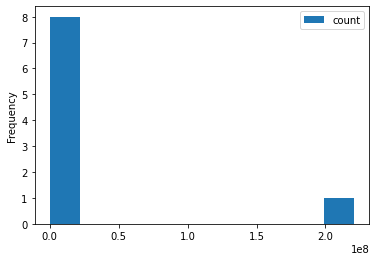

In [ ]:
df_dups_text.groupBy("distCol").count().toPandas().plot(kind="hist", x="distCol", y="count")


The histogram shows distCol(jaccard distance>0 and <0.3) and the distribution of near-duplicates. Most near-duplicates has jaccard score very close to zero. 

### Step 4. Explain how you selected a similarity threshold for “near-duplicate”

In [ ]:
#save table as parquet
output_directory = 'gs://msca-bdp-students-bucket/shared_data/charleneyu/df_dups_40'
df_dups_40.write.format("parquet").\
mode('overwrite').\
save(output_directory)

In [ ]:
#save table as parquet
output_directory = 'gs://msca-bdp-students-bucket/shared_data/charleneyu/df_dups_30'
df_dups_30.write.format("parquet").\
mode('overwrite').\
save(output_directory)

In [7]:
output_directory= 'gs://msca-bdp-students-bucket/shared_data/charleneyu/df_dups_30'
df_dups_30 = spark.read.parquet(output_directory) 

In [10]:
records = 4337628
dups = df_dups_30.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {0.3 } jaccard distance: ', dups)
print ('Unique titles based on {0.3 } jaccard distance: ', uniques)

Total records:  4337628
Duplicate titles based on {0.3 } jaccard distance:  759456
Unique titles based on {0.3 } jaccard distance:  3578172


In [58]:
records = 4337628
dups = df_dups_30.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  4337628
Duplicate titles based on { 0.4 } jaccard distance:  746611
Unique titles based on { 0.4 } jaccard distance:  0.4 :  3591017


In [34]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import pyspark.sql.functions as f
from itertools import chain
from pyspark.sql.functions import create_map, lit

take_first = udf(lambda rows: [  rows[0]], ArrayType(StringType()))

df_dups_30=df_dups_30.withColumn("type_user", take_first("text_A"))
#df_dups_30.withColumn("type_user", f.col("text_A")[0]).show()

#from pyspark.sql.functions import substring_index
#df_dups_30=df_dups_30.withColumn("type_user", substring_index(df_dups_30.text_A, ', ', 1))

In [35]:
df_dups_30.show(1)

+-------+----+------+--------------------+--------------------+---------+
|distCol|id_A|  id_B|              text_A|              text_B|type_user|
+-------+----+------+--------------------+--------------------+---------+
|    0.0|   3|106817|[others, 14545657...|[others, 14491571...| [others]|
+-------+----+------+--------------------+--------------------+---------+
only showing top 1 row



In [39]:
df_dups_30_group=df_dups_30.groupBy("type_user").agg(countDistinct('id_A').alias('dup_tweet_count'))

In [40]:
df_dups_30_group.toPandas().to_csv('df_dups_30_group.csv')

In [45]:
df_dups_30_group=df_dups_30_group.toPandas()

In [56]:
df_dups_30_group['type_user']=df_dups_30_group.type_user.apply(''.join)

In [57]:
df_user_cleaned_influ_ct=pd.read_csv('df_user_cleaned_influ_ct.csv')

In [61]:
df_dups_30_group=df_dups_30_group.merge(df_user_cleaned_influ_ct, on='type_user', how='left')

In [82]:
df_dups_30_group1=df_dups_30_group[['type_user','dup_tweet_count','total_tweet_count']]
df_dups_30_group1['unique_tweet_count']=df_dups_30_group1.total_tweet_count-df_dups_30_group1.dup_tweet_count

<ipython-input-82-cb1f31435747>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dups_30_group1['unique_tweet_count']=df_dups_30_group1.total_tweet_count-df_dups_30_group1.dup_tweet_count


In [84]:
df_dups_30_group1.index=df_dups_30_group1.type_user

In [97]:
df_dups_30_group1T=df_dups_30_group1.transpose().rename_axis('type_user', axis=1)
df_dups_30_group1T=df_dups_30_group1T.drop('type_user')

In [98]:
df_dups_30_group1T

type_user,news,others,health_org,influencers,government
dup_tweet_count,33970,680317,6793,32033,6343
total_tweet_count,179693,14259820,50632,488537,40083
unique_tweet_count,145723,13579503,43839,456504,33740


In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

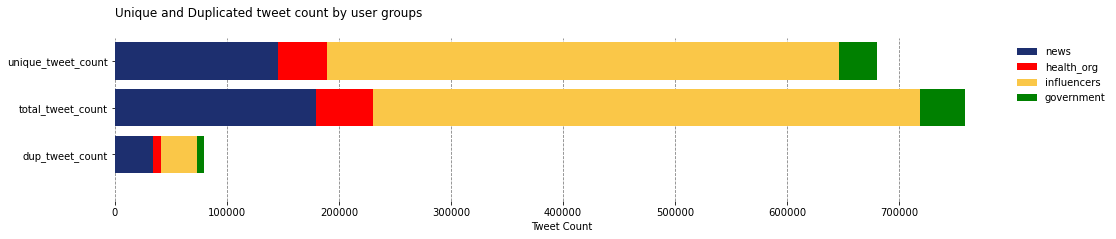

In [123]:
fields = ['news','health_org','influencers','government']
colors = [ '#1D2F6F', '#FF0000', '#FAC748','#008000']
labels = ['news','health_org','influencers','government']
# figure and axis
fig, ax = plt.subplots(1, figsize=(16, 3))
# plot bars
left = len(df_dups_30_group1T) * [0]
for idx, name in enumerate(fields):
    plt.barh(df_dups_30_group1T.index, df_dups_30_group1T[name], left = left, color=colors[idx])
    left = left + df_dups_30_group1T[name]
# title, legend, labels
plt.title('Unique and Duplicated tweet count by user groups\n', loc='left')
plt.legend(labels, bbox_to_anchor=([1, 1, 0, 0]), ncol=1, frameon=False)
plt.xlabel('Tweet Count')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-1, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

In [124]:
df_dups_30_group1

,type_user,dup_tweet_count,total_tweet_count,unique_tweet_count
type_user,,,,
news,news,33970,179693,145723
others,others,680317,14259820,13579503
health_org,health_org,6793,50632,43839
influencers,influencers,32033,488537,456504
government,government,6343,40083,33740


In [126]:
df_dups_30_group1pie=df_dups_30_group1
df_dups_30_group1pie.index=df_dups_30_group1pie.type_user

<AxesSubplot:title={'center':'Duplicated tweet count by user groups'}, ylabel='dup_tweet_count'>

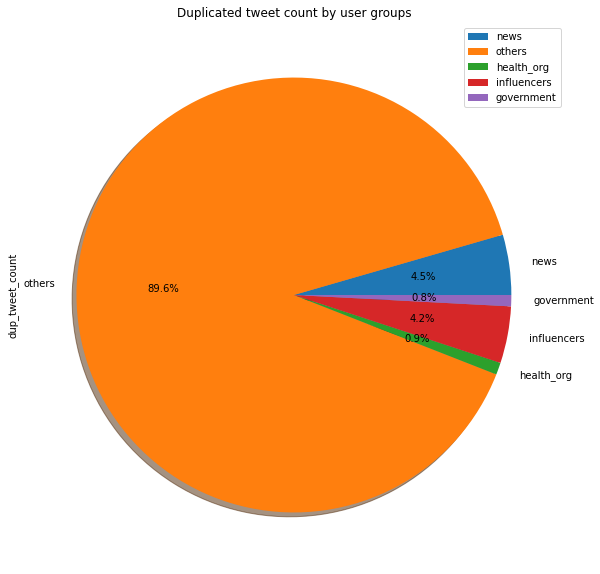

In [127]:
df_dups_30_group1pie.plot.pie(y='dup_tweet_count', title="Duplicated tweet count by user groups",\
                                  figsize=(15, 10),autopct='%1.1f%%',legend=True, shadow=True, startangle=0)

In [128]:
df_user_cleaned_influ_ct

,Unnamed: 0,type_user,original_tweet_count,total_tweet_count,total_times_being_retweeted,number_of_user,original_tweet_per_user
0,0,news,146213,179693,0,12288,11.898844
1,1,others,3988948,14259820,0,3146835,1.267606
2,2,health_org,29218,50632,0,6659,4.387746
3,3,influencers,146998,488537,0,37216,3.949860
4,4,government,26251,40083,0,5532,4.745300


In [129]:
df_user_cleaned_influ_ct['retweet_per_user']=(df_user_cleaned_influ_ct.total_tweet_count\
                                              -df_user_cleaned_influ_ct.original_tweet_count)/df_user_cleaned_influ_ct.number_of_user

In [131]:
df_user_cleaned_influ_ct

,Unnamed: 0,type_user,original_tweet_count,total_tweet_count,total_times_being_retweeted,number_of_user,original_tweet_per_user,retweet_per_user
0,0,news,146213,179693,0,12288,11.898844,2.724609
1,1,others,3988948,14259820,0,3146835,1.267606,3.263874
2,2,health_org,29218,50632,0,6659,4.387746,3.215798
3,3,influencers,146998,488537,0,37216,3.949860,9.177209
4,4,government,26251,40083,0,5532,4.745300,2.500362


In [73]:
df_user_cleaned_influ_ct=pd.read_csv('df_user_cleaned_influ_ct.csv')

In [74]:
df_user_cleaned_influ_ct[['retweet_count']]=df_user_cleaned_influ_ct.total_tweet_count-df_user_cleaned_influ_ct.original_tweet_count
df_user_cleaned_influ_ct[['retweet_per_user']]=df_user_cleaned_influ_ct.retweet_count/df_user_cleaned_influ_ct.number_of_user

In [75]:
df_user_cleaned_influ_ct=df_user_cleaned_influ_ct[['type_user','total_tweet_count','original_tweet_count','retweet_count','number_of_user','original_tweet_per_user','retweet_per_user']]

In [76]:
df_user_cleaned_influ_ct

,type_user,total_tweet_count,original_tweet_count,retweet_count,number_of_user,original_tweet_per_user,retweet_per_user
0,news,179693,146213,33480,12288,11.898844,2.724609
1,others,14259820,3988948,10270872,3146835,1.267606,3.263874
2,health_org,50632,29218,21414,6659,4.387746,3.215798
3,influencers,488537,146998,341539,37216,3.949860,9.177209
4,government,40083,26251,13832,5532,4.745300,2.500362


In [77]:
import pandas as pd

table1 = {'type_user': ['news','others','health_org','influencers','government'],
          'dup_tweet_count':  ['33970','680317','6793','32033','6343']
        }

df11 = pd.DataFrame(table1)
df11['dup_tweet_count']=pd.to_numeric(df11['dup_tweet_count'])
print (df11)

     type_user  dup_tweet_count
0         news            33970
1       others           680317
2   health_org             6793
3  influencers            32033
4   government             6343


In [78]:
df_user_cleaned_influ_ct=df_user_cleaned_influ_ct.merge(df11, on="type_user", how="left")

In [79]:
df_user_cleaned_influ_ct[['unique_tweet_count']]=df_user_cleaned_influ_ct.original_tweet_count-df_user_cleaned_influ_ct.dup_tweet_count

In [80]:
df_user_cleaned_influ_ct

,type_user,total_tweet_count,original_tweet_count,retweet_count,number_of_user,original_tweet_per_user,retweet_per_user,dup_tweet_count,unique_tweet_count
0,news,179693,146213,33480,12288,11.898844,2.724609,33970,112243
1,others,14259820,3988948,10270872,3146835,1.267606,3.263874,680317,3308631
2,health_org,50632,29218,21414,6659,4.387746,3.215798,6793,22425
3,influencers,488537,146998,341539,37216,3.949860,9.177209,32033,114965
4,government,40083,26251,13832,5532,4.745300,2.500362,6343,19908


In [109]:
df13=df_user_cleaned_influ_ct[['type_user','total_tweet_count','retweet_count','dup_tweet_count','unique_tweet_count']]
#df12.index=df12.type_user

In [110]:
df13[['near_dup_ratio']]=df13.dup_tweet_count/(df13.total_tweet_count-df13.retweet_count)
df13[['unique_ratio']]=df13.unique_tweet_count/(df13.total_tweet_count-df13.retweet_count)
df13[['rewteet_ratio']]=df13.retweet_count/(df13.total_tweet_count-df13.retweet_count)

/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
<ipython-input-110-416c2a4bc897>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df13[['near_dup_ratio']]=df13.dup_tweet_count/(df13.total_tweet_count-df13.retweet_count)
/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [111]:
df13

,type_user,total_tweet_count,retweet_count,dup_tweet_count,unique_tweet_count,near_dup_ratio,unique_ratio,rewteet_ratio
0,news,179693,33480,33970,112243,0.232332,0.767668,0.228981
1,others,14259820,10270872,680317,3308631,0.170550,0.829450,2.574832
2,health_org,50632,21414,6793,22425,0.232494,0.767506,0.732904
3,influencers,488537,341539,32033,114965,0.217915,0.782085,2.323426
4,government,40083,13832,6343,19908,0.241629,0.758371,0.526913


In [112]:
df13[['type_user','near_dup_ratio','unique_ratio','rewteet_ratio']]

,type_user,near_dup_ratio,unique_ratio,rewteet_ratio
0,news,0.232332,0.767668,0.228981
1,others,0.170550,0.829450,2.574832
2,health_org,0.232494,0.767506,0.732904
3,influencers,0.217915,0.782085,2.323426
4,government,0.241629,0.758371,0.526913


In [114]:
df13[['totalper']]=df13.total_tweet_count/df13.total_tweet_count.sum()

In [115]:
df13

,type_user,total_tweet_count,retweet_count,dup_tweet_count,unique_tweet_count,near_dup_ratio,unique_ratio,rewteet_ratio,totalper
0,news,179693,33480,33970,112243,0.232332,0.767668,0.228981,0.011965
1,others,14259820,10270872,680317,3308631,0.170550,0.829450,2.574832,0.949467
2,health_org,50632,21414,6793,22425,0.232494,0.767506,0.732904,0.003371
3,influencers,488537,341539,32033,114965,0.217915,0.782085,2.323426,0.032528
4,government,40083,13832,6343,19908,0.241629,0.758371,0.526913,0.002669


In [93]:
df13.index=df13.type_user
df13=df13.drop('others')

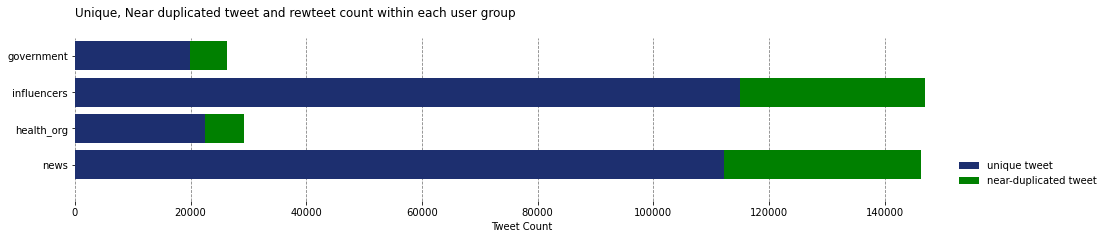

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fields = ['unique_tweet_count','dup_tweet_count']
colors = [ '#1D2F6F', '#008000','#FAC748']
labels = ['unique tweet','near-duplicated tweet']
# figure and axis
fig, ax = plt.subplots(1, figsize=(16, 3))
# plot bars
left = len(df13) * [0]
for idx, name in enumerate(fields):
    plt.barh(df13.index, df13[name], left = left, color=colors[idx])
    left = left + df13[name]
# title, legend, labels
plt.title('Unique, Near duplicated tweet and rewteet count within each user group\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.98, 0.3, 0, 0]), ncol=1, frameon=False)
plt.xlabel('Tweet Count')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-1, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()